In [1]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 68.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.1 MB/s eta 0:00:00


In [2]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=483439de096dc2af78946f03c6b53022b0251db1f2d34c7147d0f184ca28e444
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
from transformers import (AutoTokenizer, 
                          DataCollatorWithPadding, 
                          Trainer, 
                          TrainingArguments, 
                          AutoModelForSequenceClassification, 
                          EarlyStoppingCallback)
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             accuracy_score, 
                             precision_recall_fscore_support)
from langdetect import detect
from wordcloud import WordCloud
from collections import Counter
import re

plt.style.use('ggplot')


In [5]:
# Load and process dataset
def load_data(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    comment = None
    for line in lines:
        line = line.strip()
        if line.startswith("#"):
            continue
        elif line.startswith("{"):
            labels = re.findall(r"\{(.*?)\}", line)
            for label in labels:
                if "," in label:
                    aspect, sentiment = label.split(", ")
                    data.append({
                        "comment": comment.strip(),
                        "aspect": aspect.strip(),
                        "sentiment": sentiment.strip(),
                    })
        elif line:
            comment = line

    return pd.DataFrame(data)

In [6]:
# Text cleaning
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9À-ỹ\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [7]:
# Handle negation
def handle_negation(text):
    words = text.split()
    negations = {
        "không": "khong",
        "chẳng": "chang",
        "chả": "cha",
        "chưa": "chua",
        "không phải": "khong phai",
        "không bao giờ": "khong bao gio",
        "tuyệt đối không": "tuyet doi khong",
        "hoàn toàn không": "hoan toan khong",
        "chưa hề": "chua he",
        "chưa bao giờ": "chua bao gio",
        "chưa từng": "chua tung",
        "không thể": "khong the",
        "không có vẻ": "khong co ve",
        "không còn": "khong con",
        "không dám": "khong dam",
        "chưa một lần": "chua mot lan",
        "chẳng bao giờ": "chang bao gio"
    }
    processed_words = []
    for i, word in enumerate(words):
        if word in negations:
            processed_words.append(negations[word])
            if i + 1 < len(words):
                processed_words[-1] += f"_{words[i + 1]}"
        else:
            processed_words.append(word)
    return " ".join(processed_words)
    
# Remove stopwords
def remove_stopwords(text):
    stopwords = {
        "là", "của", "và", "có", "cho", "được", "không", "rất", "với", "này", "như", "để", "thì",
        "còn", "tôi", "chúng", "một", "nhưng", "đó", "ở", "khi", "nào", "sao", "cũng", "nên"
    }
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return " ".join(filtered_words)

In [8]:
# Dataset class for PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [9]:
# File path (replace with your actual file path)
file_path = "/kaggle/input/traincomment/Train.txt"


In [10]:
# Load and preprocess data
df = load_data(file_path)
df["comment"] = df["comment"].apply(clean_text).apply(handle_negation).apply(remove_stopwords)

# Encode labels
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
df["sentiment"] = df["sentiment"].map(sentiment_mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["comment"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"]
)


In [11]:
# Load PhoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

# Tokenize data
def tokenize_data(comments):
    return tokenizer(
        comments.tolist(),
        max_length=256,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )

train_encodings = tokenize_data(X_train)
test_encodings = tokenize_data(X_test)

# Create datasets
train_dataset = SentimentDataset(train_encodings, y_train.tolist())
test_dataset = SentimentDataset(test_encodings, y_test.tolist())

# Data collator (tự động padding theo batch)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [18]:
training_args = TrainingArguments(
    output_dir="./results",  # Thư mục lưu kết quả
    num_train_epochs=5,  # Tăng số epoch để học sâu hơn
    per_device_train_batch_size=16,  # Batch size lớn hơn nếu GPU cho phép
    per_device_eval_batch_size=16,
    warmup_steps=1000,  # Tăng warm-up steps để khởi động tốt hơn
    weight_decay=0.01,  # Weight decay để regularization
    logging_dir="./logs",  # Thư mục ghi log
    logging_steps=200,  # Ghi log sau mỗi 200 bước
    evaluation_strategy="epoch",  # Đánh giá sau mỗi epoch
    save_strategy="epoch",  # Lưu mô hình sau mỗi epoch
    load_best_model_at_end=True,  # Tải mô hình tốt nhất sau khi train
    metric_for_best_model="f1",  # Chọn F1 làm tiêu chí tốt nhất
    fp16=True,  # Mixed precision để tăng tốc huấn luyện
    report_to="none",  # Không dùng WandB
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [20]:
# 3. Sử dụng mô hình PhoBERT và tăng dropout
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base-v2",
    num_labels=3,
    hidden_dropout_prob=0.3,  # Tăng dropout để giảm overfitting
    attention_probs_dropout_prob=0.3
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# 4. Sử dụng Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Dừng sớm nếu không cải thiện sau 2 epoch
)


In [26]:
# Train model
trainer.train()

<ipython-input-8-016044f5030e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.844600,0.716394,0.701374,0.702722,0.709208,0.701374
2,0.764200,0.640528,0.735729,0.723351,0.727696,0.735729
3,0.697600,0.613670,0.747357,0.738682,0.741756,0.747357
4,0.627900,0.602397,0.753171,0.740047,0.745979,0.753171
5,0.568700,0.612713,0.755814,0.741543,0.749369,0.755814


<ipython-input-8-016044f5030e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-016044f5030e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-016044f5030e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-016044f5030e>:11: UserWarning: To copy construct from a 

TrainOutput(global_step=2365, training_loss=0.7083556999867865, metrics={'train_runtime': 427.0237, 'train_samples_per_second': 88.59, 'train_steps_per_second': 5.538, 'total_flos': 1723421664148464.0, 'train_loss': 0.7083556999867865, 'epoch': 5.0})

In [27]:
# Evaluate model
results = trainer.evaluate()
print("Evaluation Results:", results)

<ipython-input-8-016044f5030e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation Results: {'eval_loss': 0.6127126216888428, 'eval_accuracy': 0.7558139534883721, 'eval_f1': 0.7415426201287376, 'eval_precision': 0.7493691647078907, 'eval_recall': 0.7558139534883721, 'eval_runtime': 4.6605, 'eval_samples_per_second': 405.963, 'eval_steps_per_second': 25.534, 'epoch': 5.0}


In [28]:
# Predict single comment
def predict_sentiment(comment):
    model.eval()
    inputs = tokenizer(
        comment,
        return_tensors="pt",
        max_length=256,
        padding="max_length",
        truncation=True
    )
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
        return sentiment_map[prediction]

# Test prediction
sample_comment = "Giá cả rất hợp lý và chất lượng món ăn tuyệt vời."
print("Prediction for sample comment:", predict_sentiment(sample_comment))

Prediction for sample comment: positive


In [29]:
# Đọc dữ liệu từ file comments.csv
comments_file_path = "/kaggle/input/comment/comments.csv"
comments_df = pd.read_csv(comments_file_path)

In [44]:
# Hàm dự đoán cảm xúc
def predict_sentiment(comment):
    model.eval()
    inputs = tokenizer(
        comment,
        return_tensors="pt",
        max_length=256,
        padding="max_length",
        truncation=True
    )
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
        return sentiment_map[prediction]

# Áp dụng mô hình dự đoán cảm xúc vào dữ liệu
comments_df["Predicted_Sentiment"] = comments_df["description"].apply(predict_sentiment)


In [35]:
# Chuyển rate về số
comments_df["rate"] = pd.to_numeric(comments_df["rate"], errors="coerce")

In [46]:
neutral_count = comments_df['Predicted_Sentiment'].value_counts().get('neutral', 0)
print(f"Số lượng neutral: {neutral_count}")


Số lượng neutral: 357


In [47]:
# Gán điểm số cho cảm xúc
sentiment_scores = {"negative": 1, "neutral": 2, "positive": 3}
comments_df["Sentiment_Score"] = comments_df["Predicted_Sentiment"].map(sentiment_scores)

In [51]:
# Chuẩn hóa Sentiment_Score về thang điểm 1-10
comments_df["Sentiment_Score"] = ((comments_df["Sentiment_Score"] - 1) / 2) * 9 + 1

# Tính điểm trung bình giữa rate và cảm xúc
comments_df["Avg_Combined_Score"] = (comments_df["rate"] + comments_df["Sentiment_Score"]) / 2

In [53]:
# Nhóm theo restaurantId
restaurant_analysis = comments_df.groupby("restaurantId").agg(
    Avg_Rate=("rate", "mean"),
    Avg_Sentiment_Score=("Sentiment_Score", "mean"),
    Avg_Combined_Score=("Avg_Combined_Score", "mean"),
    Positive_Count=("Predicted_Sentiment", lambda x: (x == "positive").sum()),
    Negative_Count=("Predicted_Sentiment", lambda x: (x == "negative").sum()),
    Neutral_Count=("Predicted_Sentiment", lambda x: (x == "neutral").sum()),
    Total_Reviews=("Predicted_Sentiment", "count")
).reset_index()


In [54]:
restaurant_analysis

,restaurantId,Avg_Rate,Avg_Sentiment_Score,Avg_Combined_Score,Positive_Count,Negative_Count,Neutral_Count,Total_Reviews
0,67812ec1514dba6089ed92ac,5.260000,5.800000,5.530000,15,13,2,30
1,67812ec1514dba6089ed92ad,6.600000,5.500000,6.050000,1,1,0,2
2,67812ec1514dba6089ed92ae,8.800000,10.000000,9.400000,1,0,0,1
3,67812ec1514dba6089ed92af,5.833333,5.500000,5.666667,3,3,0,6
4,67812ec1514dba6089ed92b0,6.771429,7.428571,7.100000,10,4,0,14
...,...,...,...,...,...,...,...,...
446,67812ec1514dba6089ed9491,7.600000,10.000000,8.800000,2,0,0,2
447,67812ec1514dba6089ed9493,7.000000,10.000000,8.500000,1,0,0,1
448,67812ec1514dba6089ed9496,5.000000,1.000000,3.000000,0,1,0,1
449,67812ec1514dba6089ed9497,7.000000,7.000000,7.000000,2,1,0,3


In [55]:
# Tính tỷ lệ cảm xúc
restaurant_analysis["Positive_Rate"] = restaurant_analysis["Positive_Count"] / restaurant_analysis["Total_Reviews"]
restaurant_analysis["Negative_Rate"] = restaurant_analysis["Negative_Count"] / restaurant_analysis["Total_Reviews"]
restaurant_analysis["Neutral_Rate"] = restaurant_analysis["Neutral_Count"] / restaurant_analysis["Total_Reviews"]


In [56]:
restaurant_analysis

,restaurantId,Avg_Rate,Avg_Sentiment_Score,Avg_Combined_Score,Positive_Count,Negative_Count,Neutral_Count,Total_Reviews,Positive_Rate,Negative_Rate,Neutral_Rate
0,67812ec1514dba6089ed92ac,5.260000,5.800000,5.530000,15,13,2,30,0.500000,0.433333,0.066667
1,67812ec1514dba6089ed92ad,6.600000,5.500000,6.050000,1,1,0,2,0.500000,0.500000,0.000000
2,67812ec1514dba6089ed92ae,8.800000,10.000000,9.400000,1,0,0,1,1.000000,0.000000,0.000000
3,67812ec1514dba6089ed92af,5.833333,5.500000,5.666667,3,3,0,6,0.500000,0.500000,0.000000
4,67812ec1514dba6089ed92b0,6.771429,7.428571,7.100000,10,4,0,14,0.714286,0.285714,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
446,67812ec1514dba6089ed9491,7.600000,10.000000,8.800000,2,0,0,2,1.000000,0.000000,0.000000
447,67812ec1514dba6089ed9493,7.000000,10.000000,8.500000,1,0,0,1,1.000000,0.000000,0.000000
448,67812ec1514dba6089ed9496,5.000000,1.000000,3.000000,0,1,0,1,0.000000,1.000000,0.000000
449,67812ec1514dba6089ed9497,7.000000,7.000000,7.000000,2,1,0,3,0.666667,0.333333,0.000000


In [57]:
restaurant_analysis["Final_Score"] = (
    restaurant_analysis["Avg_Combined_Score"] +
    (restaurant_analysis["Positive_Rate"] * 2) +
    (restaurant_analysis["Neutral_Rate"] * 1) -
    (restaurant_analysis["Negative_Rate"] * 2)
)


In [59]:
# Chuẩn hóa Final_Score về thang điểm 1-10
min_score = restaurant_analysis["Final_Score"].min()
max_score = restaurant_analysis["Final_Score"].max()
restaurant_analysis["Final_Score_Normalized"] = 1 + 9 * (restaurant_analysis["Final_Score"] - min_score) / (max_score - min_score)


In [60]:
# Xác định loại nhà hàng dựa trên Final_Score
def classify_restaurant(score):
    if score >= 7:
        return "Positive"
    elif score >= 4:
        return "Neutral"
    else:
        return "Negative"

restaurant_analysis["Category"] = restaurant_analysis["Final_Score_Normalized"].apply(classify_restaurant)

# Sắp xếp nhà hàng theo điểm xếp hạng
restaurant_ranking = restaurant_analysis.sort_values(by="Final_Score_Normalized", ascending=False)


In [61]:
restaurant_analysis

,restaurantId,Avg_Rate,Avg_Sentiment_Score,Avg_Combined_Score,Positive_Count,Negative_Count,Neutral_Count,Total_Reviews,Positive_Rate,Negative_Rate,Neutral_Rate,Final_Score,Final_Score_Normalized,Category
0,67812ec1514dba6089ed92ac,5.260000,5.800000,5.530000,15,13,2,30,0.500000,0.433333,0.066667,5.730000,5.659231,Neutral
1,67812ec1514dba6089ed92ad,6.600000,5.500000,6.050000,1,1,0,2,0.500000,0.500000,0.000000,6.050000,5.880769,Neutral
2,67812ec1514dba6089ed92ae,8.800000,10.000000,9.400000,1,0,0,1,1.000000,0.000000,0.000000,11.400000,9.584615,Positive
3,67812ec1514dba6089ed92af,5.833333,5.500000,5.666667,3,3,0,6,0.500000,0.500000,0.000000,5.666667,5.615385,Neutral
4,67812ec1514dba6089ed92b0,6.771429,7.428571,7.100000,10,4,0,14,0.714286,0.285714,0.000000,7.957143,7.201099,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,67812ec1514dba6089ed9491,7.600000,10.000000,8.800000,2,0,0,2,1.000000,0.000000,0.000000,10.800000,9.169231,Positive
447,67812ec1514dba6089ed9493,7.000000,10.000000,8.500000,1,0,0,1,1.000000,0.000000,0.000000,10.500000,8.961538,Positive
448,67812ec1514dba6089ed9496,5.000000,1.000000,3.000000,0,1,0,1,0.000000,1.000000,0.000000,1.000000,2.384615,Negative
449,67812ec1514dba6089ed9497,7.000000,7.000000,7.000000,2,1,0,3,0.666667,0.333333,0.000000,7.666667,7.000000,Positive


In [62]:
# Sắp xếp nhà hàng theo điểm xếp hạng
restaurant_ranking = restaurant_analysis.sort_values(by="Final_Score_Normalized", ascending=False)


count    451.000000
mean       7.588861
std        2.002113
min        1.000000
25%        6.558654
50%        8.020000
75%        9.169231
max       10.000000
Name: Final_Score_Normalized, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


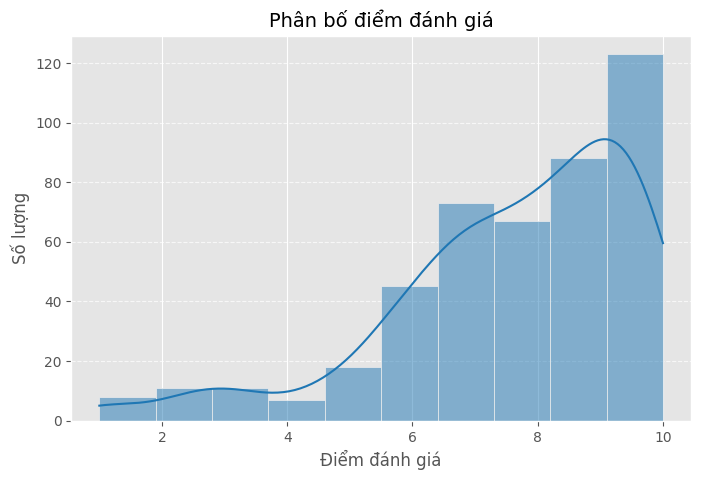

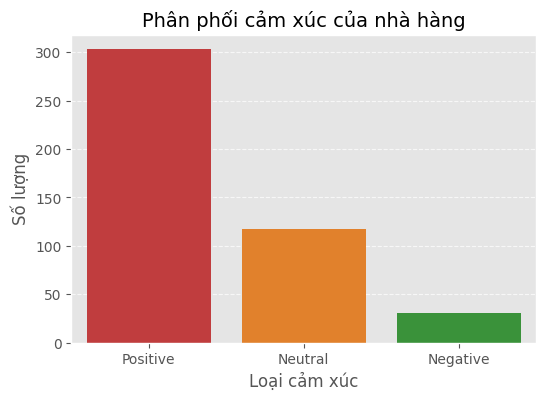

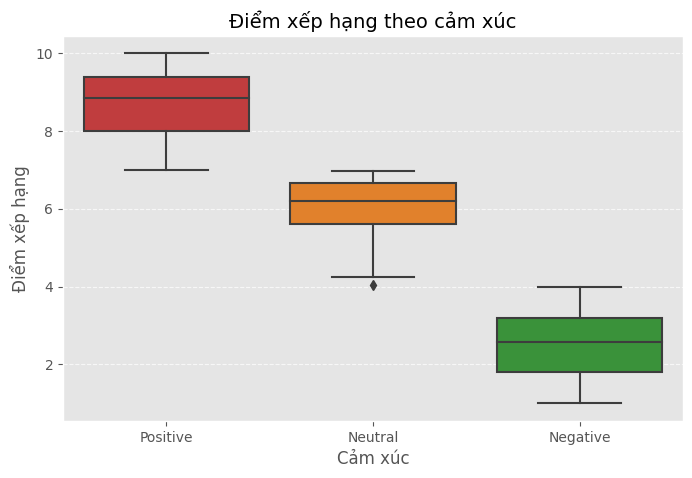

In [64]:
# Hiển thị thống kê mô tả của điểm đánh giá
print(restaurant_ranking['Final_Score_Normalized'].describe())

# Vẽ biểu đồ phân bố điểm đánh giá
plt.figure(figsize=(8, 5))
sns.histplot(restaurant_ranking['Final_Score_Normalized'], bins=10, kde=True, color='#1f77b4')  # Màu xanh đậm
plt.title('Phân bố điểm đánh giá', fontsize=14)
plt.xlabel('Điểm đánh giá', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Vẽ biểu đồ phân phối cảm xúc với màu sắc nổi bật
plt.figure(figsize=(6, 4))
sns.countplot(data=restaurant_ranking, x='Category', palette=['#d62728', '#ff7f0e', '#2ca02c'])  # Đỏ, cam, xanh lá
plt.title('Phân phối cảm xúc của nhà hàng', fontsize=14)
plt.xlabel('Loại cảm xúc', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# So sánh điểm xếp hạng giữa các nhóm cảm xúc
plt.figure(figsize=(8, 5))
sns.boxplot(data=restaurant_ranking, x='Category', y='Final_Score_Normalized', palette=['#d62728', '#ff7f0e', '#2ca02c'])
plt.title('Điểm xếp hạng theo cảm xúc', fontsize=14)
plt.xlabel('Cảm xúc', fontsize=12)
plt.ylabel('Điểm xếp hạng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [65]:
# Lưu kết quả vào file CSV
restaurant_ranking.to_csv("restaurant_ranking.csv", index=False)

In [68]:
def sort_restaurants(ranking_path, restaurants_path, output_path):
    # Đọc dữ liệu từ file
    ranking_df = pd.read_csv(ranking_path)
    restaurants_df = pd.read_csv(restaurants_path)
    
    # Đổi tên cột restaurantId trong ranking_df để khớp với _id trong restaurants_df
    ranking_df.rename(columns={"restaurantId": "_id"}, inplace=True)
    
    # Gộp dữ liệu theo _id
    merged_df = ranking_df.merge(restaurants_df, on="_id", how="left")
    
    # Chọn các cột cần thiết
    selected_columns = [
        "_id", "name", "cuisines", "address", "locationRate", "qualityRate", "serviceRate", 
        "priceRate", "spaceRate", "avgRating", "priceRange", "timeOpen", 
        "Final_Score_Normalized", "Category"
    ]
    sorted_df = merged_df[selected_columns]
    
    # Lưu vào file mới
    sorted_df.to_csv(output_path, index=False)
    

# Đường dẫn tệp
ranking_file = "restaurant_ranking.csv"
restaurants_file = "/kaggle/input/restaurants/restaurants.csv"
output_file = "sorted_restaurants.csv"

# Gọi hàm
sort_restaurants(ranking_file, restaurants_file, output_file)